In [130]:
### Author: Hojune Kim, Gary Chen
### Date: June 27, 2023
### Last Updated: Jun 27, 2023
### Description: Radon Transform (image/obj -> sinogram/measurements), but going from opposite direction

import torch
import torch.fft
import torch.nn.functional as F

import os
import math
import numpy as np
import matplotlib.pyplot as plt

# # Change this part to move to the correct directory
# !pwd
# new_directory = 'global/u1/h/hojunek/RadonTorch/'
# os.chdir(new_directory)

current_directory = os.getcwd()
print("Current directory:", current_directory)
files = os.listdir(current_directory)
print(files)

Current directory: /global/u1/h/hojunek/RadonTorch
['dataset_foam', 'forwardRadon', '.DS_Store', 'data', 'inverseRadon', '.git']


In [135]:
#####################
# helper function
#####################
def plot_1D_tensor(tensor):
    if isinstance(tensor, np.ndarray):
        # Plot the NumPy array directly
        tensor_array = tensor
    elif torch.is_tensor(tensor):
        # Move tensor to CPU if it resides on a CUDA device
        if tensor.is_cuda:
            tensor = tensor.cpu()

        # Convert tensor to a NumPy array
        tensor_array = tensor.numpy()
    else:
        raise ValueError("Unsupported input type. The input should be a PyTorch tensor or a NumPy array.")

    # Plot the tensor
    plt.plot(tensor_array)
    plt.title("1D Tensor Plot")
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.show()

def plot_2_img_tensors(image1, image2, title1='img1', title2='img2'):
    # Convert complex-valued tensors to magnitude spectra
    if torch.is_complex(image1):
        image1 = torch.abs(image1)
    if torch.is_complex(image2):
        image2 = torch.abs(image2)

    # Convert tensors to CPU and numpy arrays
    image1_cpu = image1.detach().cpu().numpy()
    image2_cpu = image2.detach().cpu().numpy()

    # Plot the images
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(image1_cpu, cmap='gray')
    axs[0].set_title(title1)
    axs[1].imshow(image2_cpu, cmap='gray')
    axs[1].set_title(title2)
    plt.show()

def compare_2img_tensors(image1, image2, title1="img1", title2="img2"):
    image1_cpu = np.abs(image1.cpu().numpy())  # Take absolute value for complex tensor
    image2_cpu = np.abs(image2.cpu().numpy())  # Take absolute value for complex tensor
    difference_cpu = np.abs(image1.cpu() - image2.cpu()).numpy()  # Compute the absolute difference
    
    # Calculate average error
    average_error = np.sum(difference_cpu) / np.prod(difference_cpu.shape)
    
    # Plot the images
    fig, axs = plt.subplots(1, 3)
    axs[0].imshow(image1_cpu, cmap='gray')
    axs[0].set_title(title1)
    axs[1].imshow(image2_cpu, cmap='gray')
    axs[1].set_title(title2)
    axs[2].imshow(difference_cpu, cmap='gray')
    axs[2].set_title("Difference")
    plt.show()
    
    return average_error
    
class Data_loader:
    # load .npy file into PyTorch tensor and move it to GPU
    def __init__(self):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def npy_to_tensor(self, npy_file_path):
        np_data = np.load(npy_file_path)
        tensor = torch.from_numpy(np_data).to(self.device)
        return tensor
data_loader = Data_loader()

def high_pass_filter(image, kernel_size):
    # Define the high-pass filter kernel
    kernel = torch.tensor([
        [-1, -1, -1],
        [-1,  8, -1],
        [-1, -1, -1]
    ]).unsqueeze(0).unsqueeze(0).float()  # Convert to 4D tensor

    # Move the filter kernel to the same device as the input tensor
    kernel = kernel.to(image.device)

    # Apply the convolution operation with the kernel
    filtered_image = F.conv2d(image, kernel, padding=kernel_size//2)

    # Remove the batch and channel dimensions
    filtered_image = filtered_image.squeeze()
    
    return filtered_image

# check GPU
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f'Using device: {device}')


Using device: cuda


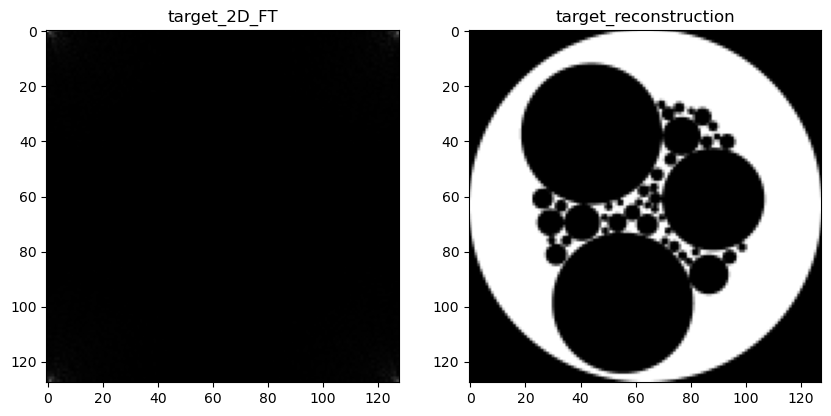

In [136]:
# Load data
sinogram_batch = data_loader.npy_to_tensor('./data/sinogram_batch_no_padding.npy')
object_batch = data_loader.npy_to_tensor('./dataset_foam/foam_training.npy')
sinogram1 = sinogram_batch[0,:,:]
object1 = object_batch[0,:,:]

target_2D_FT = torch.fft.fft2(object1)
target_reconstruction = torch.fft.ifft2(target_2D_FT)
plot_2_img_tensors(target_2D_FT,target_reconstruction,"target_2D_FT","target_reconstruction")

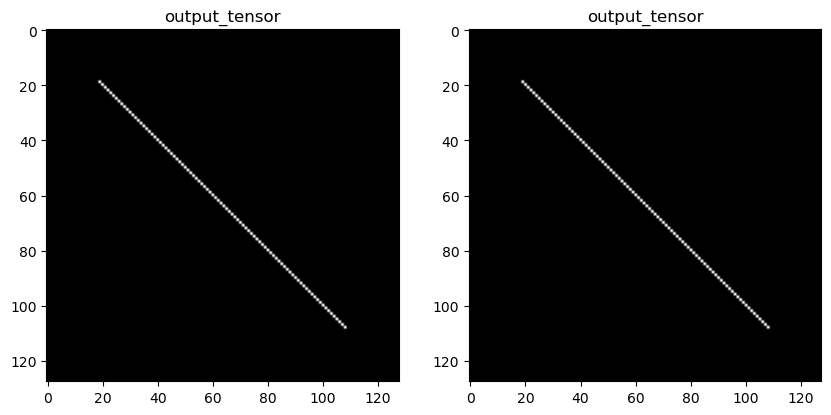

In [182]:
def rotate_1D_to_2D_tensor(input_tensor, theta):
    img_size = input_tensor.size(0)

    input_tensor = input_tensor.to(device)
    output_tensor = torch.zeros((img_size*2, img_size*2)).to(device)

    center_x = img_size
    center_y = img_size

    theta_rad = torch.from_numpy(np.array(math.radians(theta))).to(torch.float32)

    x = torch.arange(img_size)

    new_x1 = (center_x + x * torch.cos(theta_rad)).to(torch.long)
    new_y1 = (center_y + x * torch.sin(theta_rad)).to(torch.long)
    new_x2 = (center_x - x * torch.cos(theta_rad)).to(torch.long)
    new_y2 = (center_y - x * torch.sin(theta_rad)).to(torch.long)

    output_tensor[new_x1, new_y1] = input_tensor[x]
    output_tensor[new_x2, new_y2] = input_tensor[x]
    
    reshaped_tensor = F.interpolate(output_tensor.unsqueeze(0).unsqueeze(0), size=(img_size, img_size), mode='bilinear').squeeze()

    return reshaped_tensor

# Example usage
input_tensor = torch.ones(128)  # Example 1D tensor of size [128]
theta = 45  # Rotation angle in degrees
output_tensor = rotate_1D_to_2D_tensor(input_tensor, theta)
plot_2_img_tensors(output_tensor, output_tensor, "output_tensor", "output_tensor")

128
180


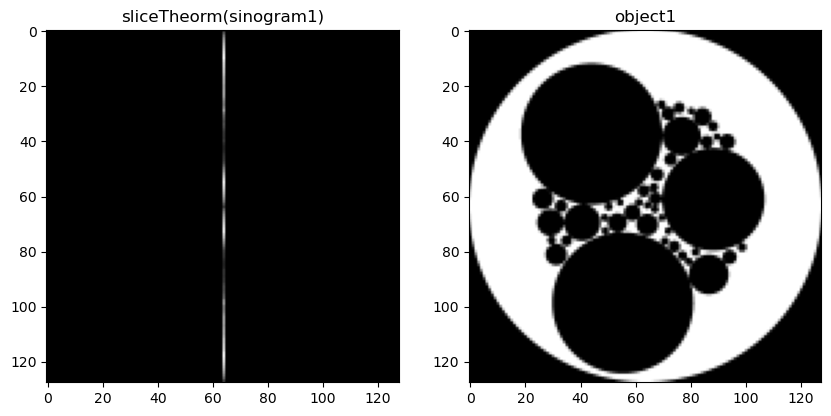

In [192]:
def sliceTheorm(sinogram):
    img_size = sinogram.size(1)
    print(img_size)
    num_angles = sinogram.size(0)
    print(num_angles)
    output_tensor = torch.zeros((img_size, img_size)).to(device)

    for angle in range(num_angles):
        output_tensor += rotate_1D_to_2D_tensor(sinogram[angle], angle)
        break
    return output_tensor

plot_2_img_tensors(sliceTheorm(sinogram1), object1, "sliceTheorm(sinogram1)", "object1")
        

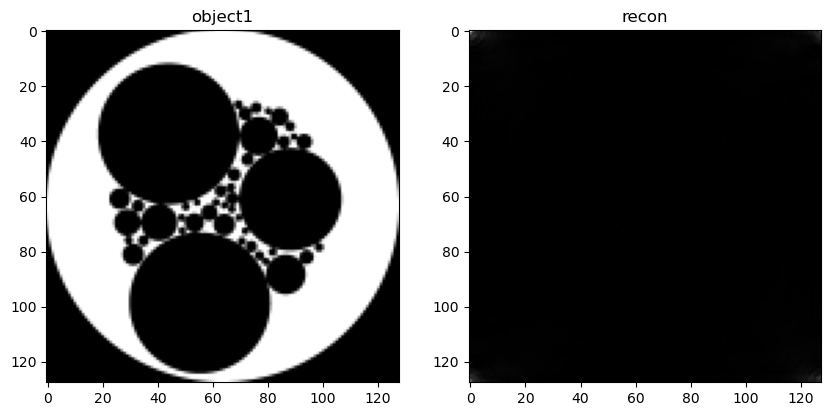

In [185]:
def iradon(sinogram):
    radon_image_temp = sinogram.unsqueeze(0).unsqueeze(0).to(device)  # Add batch and channel dimensions
    filtered_img = high_pass_filter(radon_image_temp, 3)

    num_angles = filtered_img.size(0) #180
    output_size = filtered_img.size(1) #128
    img_2D_FT = torch.zeros((output_size, output_size)).to(device)

    for angle in range(num_angles):
        slice = rotate_1D_to_2D_tensor(filtered_img[angle], angle)
        img_2D_FT += slice
    img_2D_FT = img_2D_FT / num_angles
    return (img_2D_FT) # torch.fft.ifft2

recon = iradon(sinogram1)
plot_2_img_tensors(object1,recon,"object1","recon")